# Open Food Facts : Notebook d'analyse exploratoire

1. [Importer librairies](#importer-librairies)
2. [Lecture des données](#lecture-des-donnees)
3. [Analyse variable principale: pays](#pays)
4. [Analyse nutriments et pays](#nutri-pays)
    * [Mesures de tendances nutriments (univariée)](#nutri-uni)
    * [Mesures de tendances nutriments par pays (bivariée)](#nutri-pays-bi)
        - [Test d'hypothèse: taux de sucre, États-Unis vs France](#test)
    * [Repartition nutriscore (univariée)](#nutri)
    * [Repartition nutriscore par pays (bivariée)](#nutriscore-pays)
5. [Analyse bivariée entre nutriments](#nutri-bi)
    * [Une étude de correlation: sucres et féculents](#sucre-carbo)
6. [Conclusions analyse exploratoire](#conclusions)

Ce notebook fait partie du projet - Concevez une application au service de la santé publique - d'OpenClassrooms.

**Étudiant :** Ana Bernal

## 1. Importer librairies <a class="anchor" id="importer-libraires"></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
from scipy import stats

sns.set_theme()  # Établir le thème par défaut de seaborn

## 2. Lecture des données <a class="anchor" id="lecture-des-données"></a>

In [2]:
food_data = pd.read_csv('food_data_clean.csv', index_col=[0])

with open('countries_list.data','rb') as fichier:
    countries_list = pickle.load(fichier)

In [3]:
food_data.head()

,countries_tags,product_name,proteins_100g,salt_100g,ingredients_text,sugars_100g,fat_100g,carbohydrates_100g,saturated-fat_100g,nutrition_grade_fr,fiber_100g,cholesterol_100g,trans-fat_100g,calcium_100g,vitamin-c_100g,iron_100g,vitamin-a_100g
0,france,Farine de blé noir,0.00,0.00000,NaN,0.00,0.00,0.00,0.00,b,0.0,0.000,0.0,0.000,0.0000,0.00000,0.0
1,united-states,Banana Chips Sweetened (Whole),3.57,0.00000,"Bananas, vegetable oil (coconut oil, corn oil ...",14.29,28.57,64.29,28.57,d,3.6,0.018,0.0,0.000,0.0214,0.00129,0.0
2,united-states,Peanuts,17.86,0.63500,"Peanuts, wheat flour, sugar, rice flour, tapio...",17.86,17.86,60.71,0.00,b,7.1,0.000,0.0,0.071,0.0000,0.00129,0.0
3,united-states,Organic Salted Nut Mix,17.86,1.22428,"Organic hazelnuts, organic cashews, organic wa...",3.57,57.14,17.86,5.36,d,7.1,0.000,0.0,0.143,0.0000,0.00514,0.0
4,united-states,Organic Polenta,8.57,0.00000,Organic polenta,0.00,1.43,77.14,0.00,a,5.7,0.000,0.0,0.000,0.0000,0.00000,0.0


## 3. Analyse variable principale: pays <a class="anchor" id="pays"></a>

Nous allons maintenant étudier quels sont les pays les plus représentés en tant que pays où les produits de la base de données sont vendus. Cela nous donnera une liste plus restrainte des pays pour lesquels on peut avoir des informations pertinantes.

Pour cela dans un premiers temps, créons un dataframe avec les informations de nombre de produits, et pourcentage par pays.

In [4]:
# Dataframe avec la colonne 'country:'
# chaque ligne correspond à un pays différent
count_countries = pd.DataFrame({'country':countries_list})

# Pour créer la colonne: 'number_of_prod', qui contient
# le nombre de produits vendu dans le pays, on
# définit d'abord la fonction suivante:

def NumberOfAppearancesInSeries(string,series):
    """
    Compte les apparitions d'un string dans une series pandas.
    
    Arguments:
        string: string
        series: pandas.Series
        
    Resultat:
        Nombre de lignes de series où string est contenue.
    """
    return series.str.contains(string).sum()


# Création de la colonne number_of_prod en "mappant"
# chaque pays de la colonne countries au nombre d'apparitions
# dans la serie food_data['countries_tags']
count_countries['number_of_prod'] = count_countries['country'].map(lambda country: NumberOfAppearancesInSeries(country,food_data['countries_tags']))

# colonne pourcentage_prod_vendu
count_countries['pourcentage_prod_vendu'] = round((count_countries['number_of_prod']/food_data.shape[0])*100,1)

# organiser par ordre décroissant de number_of_prod
count_countries.sort_values('number_of_prod', ascending=False,inplace=True,ignore_index=True)

In [5]:
count_countries.iloc[:10]

,country,number_of_prod,pourcentage_prod_vendu
0,united-states,172476,56.7
1,france,91270,30.0
2,switzerland,14783,4.9
3,germany,7631,2.5
4,spain,4932,1.6
5,united-kingdom,4301,1.4
6,belgium,2795,0.9
7,australia,1713,0.6
8,russia,1260,0.4
9,italy,1101,0.4


Comme on peut voir dans ce tableau, il y a une très faible représentation de la variété des pays. Nous allons tout de même, puisque cela correspond à notre idée d'application, selectionner le sous-échantillon des produits vendus dans les premiers 6 pays: 

* France
* États-Unis
* Suisse
* Allemagne
* Espagne
* Royaume-Uni

On fait cette filtration du dataset:

In [6]:
# copie du dataset
food_data_some_countries = food_data.copy()

# Creation d'une colonne booléenne pour chaque pays
countries = count_countries.loc[count_countries['pourcentage_prod_vendu'] >= 1]['country'].tolist()

for country in countries:
    food_data_some_countries[country] = food_data_some_countries['countries_tags'].str.contains(country)
    
# on garde seulement les produits vendu dans au moins un de ces pays:
mask = food_data_some_countries[countries].sum(axis='columns') > 0
food_data = food_data_some_countries[mask]

In [7]:
print(f'Ce qui nous laisse un total de {food_data.shape[0]} lignes.')

Ce qui nous laisse un total de 291963 lignes.


## 4. Analyses nutriments et pays <a class="anchor" id="nutri-pays"></a>

Nous ferons une analyse univarié divisé en:

* Mesures de tendances nutriments (univariée)
* Mesures de tendances nutriments **par pays** (bivariée)
* Repartition nutriscore (univariée)
* Repartition nutriscore par pays (bivariée)

La liste des variables quantitatives, les nutriments, est :

In [8]:
var_quant = food_data.select_dtypes(include=[np.number]).columns.tolist()

### Mesures de tendances nutriments (univariée) <a class="anchor" id="nutri-uni"></a>

Traçons des boîte à moustaches pour observer les distributions de quantités de nutriments par 100g du produit. Dans un premier temps pour tous les pays et ensuite par pays.

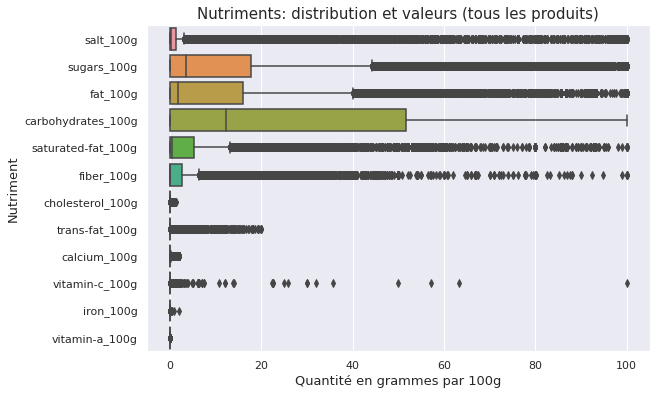

In [9]:
warnings.simplefilter(action='ignore', category=FutureWarning) # ignorer les warning de futures versions

fig = plt.figure(figsize=(9, 6))
sns.boxplot(data = food_data[var_quant[1:]], orient='h')
plt.title('Nutriments: distribution et valeurs (tous les produits)', fontsize=15)
plt.xlabel('Quantité en grammes par 100g', fontsize=13)
plt.ylabel('Nutriment', fontsize=13)
plt.show()
fig.savefig('nutriments_distr_tous.png',bbox_inches='tight')

Les chiffres concrètes de ces mesures de tendances:

In [10]:
food_data[var_quant].describe()

,proteins_100g,salt_100g,sugars_100g,fat_100g,carbohydrates_100g,saturated-fat_100g,fiber_100g,cholesterol_100g,trans-fat_100g,calcium_100g,vitamin-c_100g,iron_100g,vitamin-a_100g
count,291963.000000,291963.000000,291963.000000,291963.000000,291963.000000,291963.000000,291963.000000,291963.000000,291963.000000,291963.000000,291963.000000,291963.000000,291963.000000
mean,6.127646,1.357944,13.149907,10.327991,26.077074,3.932619,1.907302,0.008996,0.027218,0.045106,0.006579,0.000896,0.000067
std,7.878899,5.786735,20.160520,16.520437,29.121162,7.248111,3.952340,0.028264,0.440754,0.131364,0.316073,0.004954,0.000338
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.450000,0.294640,3.500000,1.790000,12.200000,0.300000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,8.900000,1.200000,17.650000,16.000000,51.760000,5.200000,2.500000,0.000000,0.000000,0.032000,0.000000,0.000900,0.000000
max,90.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,1.291000,20.000000,2.000000,100.000000,2.000000,0.010000


### Mesures de tendances nutriments par pays (bivariée) <a class="anchor" id="nutri-pays-bi"></a>

Maintenant on **regroupe ces informations par pays.** Pour cela on s'inspire de la [réponse choisie](https://stackoverflow.com/questions/43770507/seaborn-bar-plot-ordering) dans ce lien de stackoverflow.

In [11]:
# Nous appliquons la méthode melt:
# cela multiplie le nombre de lignes mais crée une colonne
# avec un unique pays

food_data_melt = pd.melt(food_data, id_vars=var_quant, value_vars=countries, var_name = 'country')
food_data_melt = food_data_melt.loc[food_data_melt['value'] == True]
food_data_melt.drop(columns='value', inplace = True)

food_data_melt.head()

,proteins_100g,salt_100g,sugars_100g,fat_100g,carbohydrates_100g,saturated-fat_100g,fiber_100g,cholesterol_100g,trans-fat_100g,calcium_100g,vitamin-c_100g,iron_100g,vitamin-a_100g,country
1,3.57,0.00000,14.29,28.57,64.29,28.57,3.6,0.018,0.0,0.000,0.0214,0.00129,0.0,united-states
2,17.86,0.63500,17.86,17.86,60.71,0.00,7.1,0.000,0.0,0.071,0.0000,0.00129,0.0,united-states
3,17.86,1.22428,3.57,57.14,17.86,5.36,7.1,0.000,0.0,0.143,0.0000,0.00514,0.0,united-states
4,8.57,0.00000,0.00,1.43,77.14,0.00,5.7,0.000,0.0,0.000,0.0000,0.00000,0.0,united-states
5,13.46,0.00000,11.54,18.27,63.46,1.92,7.7,0.000,0.0,0.038,0.0000,0.00346,0.0,united-states


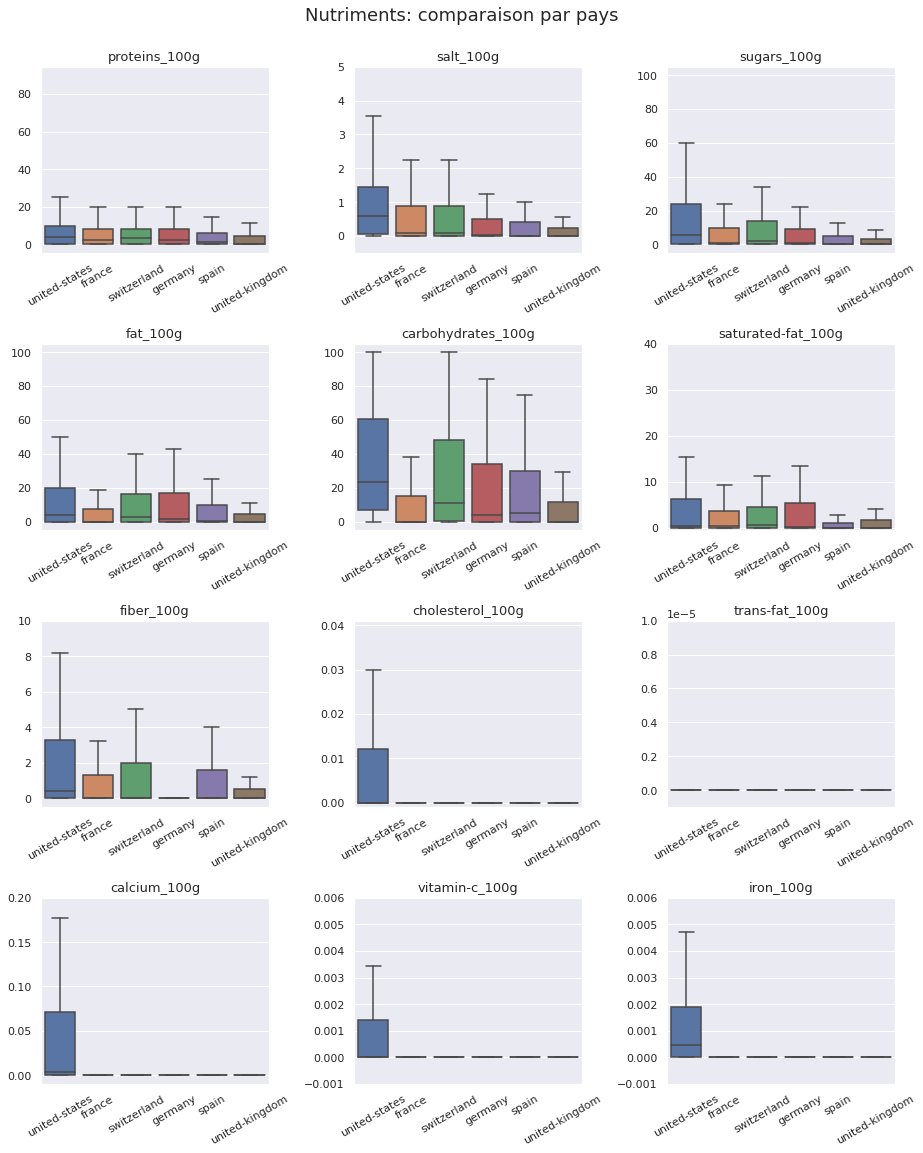

In [12]:
fig, axs = plt.subplots(4, 3, figsize = (13,16))
fig.suptitle('Nutriments: comparaison par pays', fontsize=18, y=1)

# matrice avec chaque variable pour faire graphe
matrix_var_quant = np.reshape(var_quant[:-1],(4,3))

for var in var_quant[:-1]:
    indice_var = np.where(matrix_var_quant ==var)
    i = indice_var[0][0]
    j = indice_var[1][0]

    sns.boxplot(data=food_data_melt,x='country', y=var, fliersize=0,ax=axs[i,j])
    axs[i, j].set_title(var, fontsize=13)
    axs[i,j].set(xlabel=None)
    axs[i,j].set(ylabel=None)
    axs[i,j].set_xticklabels(axs[i,j].get_xticklabels(),rotation = 30)
    
    if var in ['salt_100g']:
        axs[i,j].set_ylim(-0.5,5)
    if var in ['saturated-fat_100g']:
        axs[i,j].set_ylim(-0.5,40)
    if var in ['fiber_100g']:
        axs[i,j].set_ylim(-0.5,10)
    if var in ['cholesterol_100g', 'iron_100g']:
        axs[i,j].set_ylim(-0.001,0.041)
    if var in ['trans-fat_100g']:
        axs[i,j].set_ylim(-0.000001,0.00001)
    if var in ['calcium_100g']:
        axs[i,j].set_ylim(-0.01,0.2)
    if var in ['iron_100g', 'vitamin-c_100g']:
        axs[i,j].set_ylim(-0.001,0.006)

plt.tight_layout()
fig.savefig('nutriments_par_pays.png',bbox_inches='tight')

Les chiffres concrètes qui correspondent à ces mesures de tendance **par pays** sont :

* **La moyenne:**

In [13]:
# La moyenne par variable, par pays
food_data_melt.groupby(by = 'country').mean()

,proteins_100g,salt_100g,sugars_100g,fat_100g,carbohydrates_100g,saturated-fat_100g,fiber_100g,cholesterol_100g,trans-fat_100g,calcium_100g,vitamin-c_100g,iron_100g,vitamin-a_100g
country,,,,,,,,,,,,,
france,5.405084,0.785511,9.140372,6.908205,14.244127,3.683179,1.267244,0.000062,0.000885,0.006404,0.001633,0.000107,0.000002
germany,5.517342,0.643187,9.557026,10.479521,18.279214,4.540588,0.958860,0.000033,0.000341,0.007767,0.009741,0.000053,0.000003
spain,3.823314,0.573471,7.186486,8.583038,17.767163,2.276115,1.566248,0.000010,0.000085,0.006856,0.003205,0.000122,0.000007
switzerland,5.379204,0.756155,11.352218,10.337048,23.558414,3.989365,1.548036,0.000061,0.000069,0.006618,0.001150,0.000074,0.000004
united-kingdom,3.480804,0.392665,6.944633,6.301831,12.509354,2.620143,0.818903,0.000055,0.001597,0.004125,0.000346,0.000045,0.000003
united-states,6.729376,1.781914,15.941261,12.313002,33.526430,4.139222,2.351876,0.015203,0.045625,0.072112,0.009662,0.001453,0.000112


* **La médiane:**

In [14]:
# La médiane par variable, par pays
food_data_melt.groupby(by = 'country').median()

,proteins_100g,salt_100g,sugars_100g,fat_100g,carbohydrates_100g,saturated-fat_100g,fiber_100g,cholesterol_100g,trans-fat_100g,calcium_100g,vitamin-c_100g,iron_100g,vitamin-a_100g
country,,,,,,,,,,,,,
france,2.50,0.09000,1.10,0.0,0.000,0.35,0.0,0.0,0.0,0.000,0.0,0.00000,0.0
germany,2.40,0.03000,1.00,1.2,4.100,0.20,0.0,0.0,0.0,0.000,0.0,0.00000,0.0
spain,1.10,0.00000,0.20,0.5,5.000,0.00,0.0,0.0,0.0,0.000,0.0,0.00000,0.0
switzerland,3.20,0.10000,2.00,2.7,11.000,0.50,0.0,0.0,0.0,0.000,0.0,0.00000,0.0
united-kingdom,0.00,0.00000,0.00,0.0,0.000,0.00,0.0,0.0,0.0,0.000,0.0,0.00000,0.0
united-states,3.85,0.60452,5.36,4.0,23.125,0.31,0.4,0.0,0.0,0.004,0.0,0.00045,0.0


* **La déviation standard:**

In [15]:
# La deviation standard par variable, par pays
food_data_melt.groupby(by = 'country').std()

,proteins_100g,salt_100g,sugars_100g,fat_100g,carbohydrates_100g,saturated-fat_100g,fiber_100g,cholesterol_100g,trans-fat_100g,calcium_100g,vitamin-c_100g,iron_100g,vitamin-a_100g
country,,,,,,,,,,,,,
france,7.315373,3.482735,16.936825,13.834514,24.028939,7.434209,3.381487,0.002715,0.065391,0.058803,0.332315,0.006872,0.000057
germany,8.608270,4.197419,17.643999,16.976129,25.667156,8.488507,3.029167,0.001329,0.013248,0.066035,0.725903,0.000710,0.000044
spain,5.987562,2.914722,14.987074,16.390918,24.705370,5.516244,3.944970,0.000307,0.003499,0.042380,0.171109,0.001706,0.000113
switzerland,6.835802,3.113413,18.576314,15.857048,27.035996,7.375302,3.368839,0.003507,0.008226,0.055813,0.017942,0.000869,0.000044
united-kingdom,6.438198,1.306045,16.325254,14.201529,23.235576,6.918830,2.134491,0.001719,0.101727,0.037270,0.003722,0.000913,0.000058
united-states,8.204805,6.942532,21.644500,17.552148,29.737264,7.132826,4.266479,0.035424,0.570773,0.158817,0.294064,0.003959,0.000432


#### Test d'hypothèse: taux de sucre États-Unis vs France  <a class="anchor" id="test"></a>

À partir de ces observations nous avons l'hypothèse suivante:

> **Hypothèse nulle (H0):** La moyenne de la quantité de sucre dans les produits vendus aux États-Unis est égale à la moyenne de la quantité de sucre dans les produits vendus en France.

L'**hypothèse alternative (H1)** est: La moyenne de la quantité de sucre dans les produits vendus en France est significativement inférieure à la moyenne de la quantité de sucre dans les produits vendus aux États-Unis.

Comme ces deux variables ont una variance différente (calculée ci dessous), pour tester cet hypothèse nous avons choisi de faire un [**test t de Welch**](https://fr.wikipedia.org/wiki/Test_t_de_Welch) ce test est un test de student adapté pour des variables aléatoires avec des variances inégales et supposées d'une loi normale. ([Documentation scipy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html#scipy.stats.ttest_ind))

Nous allons aussi utiliser le [**test U de Mann-Whitney**](https://fr.wikipedia.org/wiki/Test_de_Wilcoxon-Mann-Whitney) qui est une version non paramétrique du test t pour deux variables aléatoires independantes. ([Documentation scipy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mannwhitneyu.html#scipy.stats.mannwhitneyu))

On choisit un niveau de test : $ \alpha = 0.05$

In [16]:
sucre_etatsunis = food_data.loc[food_data['united-states'] == True]['sugars_100g'].copy()
sucre_etatsunis = sucre_etatsunis[sucre_etatsunis>0]  # On garde seulement les valeurs positives 
sucre_france = food_data.loc[food_data['france'] == True]['sugars_100g'].copy()
sucre_france = sucre_france[sucre_france>0]

# Variances des deux variables:
print(f"La variance de la quantité de sucre aux États Unis est: {round(sucre_etatsunis.var(),2)}")
print(f"La variance de la quantité de sucre en France est: {round(sucre_france.var(),2)}")

La variance de la quantité de sucre aux États Unis est: 511.9
La variance de la quantité de sucre en France est: 376.28


Les tailles des échantillons sont assez différentes aussi, il y a plus de produits vendus aux États-Unis qu'en France:

In [17]:
# Tailles des échantillons:

print(f'{"Pays":<15}', 'Taille échantillon')
print('------------------------------------')
print(f'{"États-Unis":<15}',len(sucre_etatsunis))
print(f'{"France":<15}',len(sucre_france))

Pays            Taille échantillon
------------------------------------
États-Unis      128915
France          57902


**Résultats des tests d'hypothèse:**

In [18]:
# Test T de Welch
welch_test_result = stats.ttest_ind(sucre_france.values,
                                    sucre_etatsunis.values, 
                                    alternative='less')
welch_p = welch_test_result.pvalue
welch_stat = welch_test_result.statistic

# Test U de Mann et Whitney
mwu_test_result = stats.mannwhitneyu(sucre_france.values, 
                                     sucre_etatsunis.values, 
                                     alternative='less')
mwu_p = mwu_test_result.pvalue
mwu_stat = mwu_test_result.statistic

print('Les résultats des tests sont: \n')
print(f'{"Test":<20}', f'{"p-valeur":<9}', 'statistique')
print('--------------------------------------------')
print(f'{"test T de Welch":<20}',f'{welch_p:<9}',f'{round(welch_stat,2):<20}')
print(f'{"test U de M. et W.":<20}',f'{mwu_p:<9}',f'{round(mwu_stat,2):<20}')

Les résultats des tests sont: 

Test                 p-valeur  statistique
--------------------------------------------
test T de Welch      0.0       -63.81              
test U de M. et W.   0.0       2713191854.0        


**Conclusion de ces tests:** Comme la p-valeur est  $0<0.05$, nous rejettons l'hypothèse nulle.

> La moyenne de la quantité de sucre dans les produits vendus en France est significativement inférieur à la moyenne de la quantité de sucre dans les produits vendus aux États-Unis.

* du côté des statistiques des tests. Pour le test T on sait que la statistique est négative si la moyenne de la première variable est inférieure à celle de la deuxième (voir [documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html#scipy.stats.ttest_ind))

* Pour le test U, avec un si haut valeur de la statistique on conclut que ce phénomène est peu probable d'être du au hasard. (Voir [ce cours](http://users.sussex.ac.uk/~grahamh/RM1web/MannWhitneyHandout%202011.pdf), deuxième paragraphe de la première page.)

### Répartition nutriscore (univariée) <a class="anchor" id="nutri"></a>

Nous allons maintenant étudier la repartition de la note nutriscore pour tous les produits et ensuite en les comparant par pays.

D'abord voyons la repartition général des produits dans toute la base de données par nutriscore.

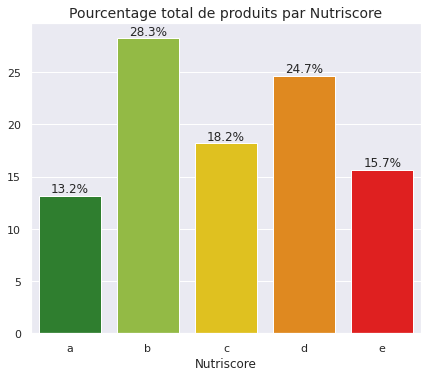

In [19]:
count_nutriscore =food_data['nutrition_grade_fr'].value_counts(normalize=True)*100

fig, ax = plt.subplots(figsize=(7,5.7))

ax = sns.barplot(x=count_nutriscore.index, 
                 y = count_nutriscore.values,  
                 order=list('abcde'), 
                 palette=['forestgreen','yellowgreen','gold','darkorange','red'])
ax.set_title('Pourcentage total de produits par Nutriscore', fontsize=14)
ax.set(xlabel='Nutriscore')
ax.bar_label(ax.containers[0], fmt='%.1f%%')
plt.show()

fig.savefig('pourcentage_prod_par_nutris.png',bbox_inches='tight')

On peut voir que la plupart de produits ont un nutriscore b, avec un pourcentage de 27%.

### Répartition nutriscore par pays (bivariée)  <a class="anchor" id="nutriscore-pays"></a>

Voyons maintenant la repartition **par pays**. Pour cela on utilise à nouveau la fonction melt de pandas.

In [20]:
countries_nutri = pd.melt(food_data, id_vars=['nutrition_grade_fr'], value_vars=countries, var_name = 'country')
countries_nutri = countries_nutri.loc[countries_nutri['value'] == True]
countries_nutri.drop(columns='value', inplace = True)

countries_nutri.head()

,nutrition_grade_fr,country
1,d,united-states
2,b,united-states
3,d,united-states
4,a,united-states
5,a,united-states


In [21]:
# Création de dataframe pour voir l'info du nutriscore par pays
nutriscore_countries = pd.DataFrame(columns=['nutriscore','country','number_prod', 'percent'])

# Aujout de lignes une par une (30 au total)
indice = -1
for letter in list('abcde'): # pour chaque nutriscore
    for country in countries: # pour chacun des 6 pays
        indice += 1 # pour rajouter une ligne il faut dire son indice dans le df
        
        # un data frame: pour le pays tout seul
        country_df = countries_nutri.loc[countries_nutri['country'] == country]  
        
        # des chiffres qui nous intéressent
        leng = country_df.shape[0] # le nombre de produits vendus dans ce pays
        number_prod = country_df.loc[country_df['nutrition_grade_fr'] == letter].shape[0] # le nombre de produits vendus dans ce pays avec ce nutriscore
        percentage = round((number_prod/leng)*100,1) # pourcentage de produits vendus dans ce pays avec le nutriscore
        
        # la ligne à rajouter
        row = pd.DataFrame({'nutriscore':letter, 'country':country, 'number_prod':number_prod, 'percent':percentage},index = [indice])
        
        # l'ajout de la ligne
        nutriscore_countries = pd.concat([nutriscore_countries,row], axis=0)

Ce qui résulte en le dataframe suivant:

In [22]:
nutriscore_countries

,nutriscore,country,number_prod,percent
0,a,united-states,23765,13.8
1,a,france,11064,12.1
2,a,switzerland,1905,12.9
3,a,germany,897,11.8
4,a,spain,865,17.5
5,a,united-kingdom,444,10.3
6,b,united-states,33288,19.3
7,b,france,36631,40.1
8,b,switzerland,5317,36.0
9,b,germany,3270,42.9


Graphiquement, nous pouvons visualiser ces informations dans un diagramme de barres.

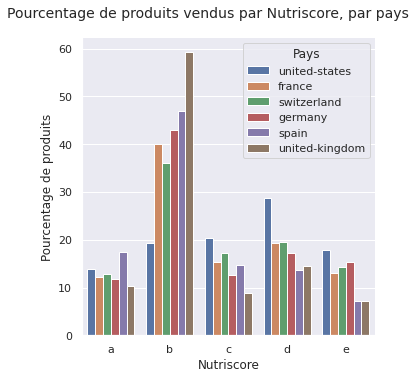

In [23]:
fig, ax = plt.subplots(figsize=(13,6))

ax = sns.catplot(data=nutriscore_countries, kind='bar',
                 x='nutriscore', y = 'percent', hue='country',
                legend=False)
ax.set_axis_labels('Nutriscore','Pourcentage de produits')
# ax.legend.set_title('Pays', fontsize=14)
# plt.legend(...,title='title',title_fontsize='large')
plt.legend(title='Pays', loc='best')
ax.fig.suptitle('Pourcentage de produits vendus par Nutriscore, par pays',y=1.05,fontsize=14)
plt.close(1)
plt.show()
# ax.savefig('pourcentage_prod_par_nutris_pays.png',bbox_inches='tight')

On peut voir que plus de 40% des produits vendus en France ont un nutriscore B, et c'est presque pareil pour le Royaume-Uni.

On peut observer que l'Allemagne a un grand taux de produits avec nutriscore E avec près de 30% alors que le reste des pays c'est en dessous de 22%.

Les produits les plus sains : ceux avec nutriscore A ont un taux semblable pour tous les pays avec entre 10 et 15 pourcent des produits.

### Analyse bivariée entre nutriments <a class="anchor" id="nutri-bi"></a>

Nous traçons un heatmap pour avoir une idée des possibles correlations entre les variables.

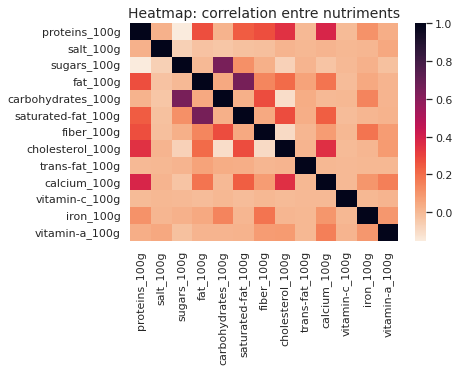

In [24]:
sns.set()
heatmap_plot = sns.heatmap(food_data[var_quant].corr(), cmap= sns.cm.rocket_r)
fig = heatmap_plot.get_figure()
plt.title('Heatmap: correlation entre nutriments', fontsize=14)
fig.savefig('heatmap.png',bbox_inches='tight')

plt.show()

#### Une étude de correlation: sucres et carbohydrates (glucides) <a class="anchor" id="sucre-carbo"></a>

Il semble y avoir une correlation entre la quantité de carbohydrates et de sucre dans les produits. On fait des graphes pour étudier cette possible correlation.

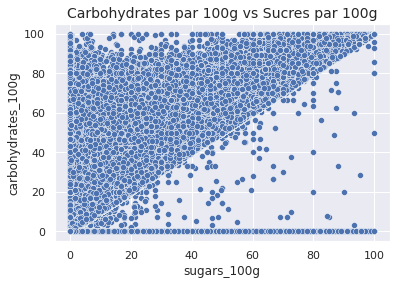

In [25]:
scatter_plot = sns.scatterplot(data=food_data,
                y='carbohydrates_100g',
                x='sugars_100g')
fig = scatter_plot.get_figure()
plt.title('Carbohydrates par 100g vs Sucres par 100g', fontsize=14)
fig.savefig('carbosucre.png',bbox_inches='tight')

plt.show()

On calcule le coefficient de correlation linéaire pour ces deux variables.

In [26]:
corre_sugar_carbo = food_data[['sugars_100g', 'carbohydrates_100g']].corr(method='pearson')
print(f'Le coefficient de correlation linéaire entre la quantité de sucre \net la cantité de carbohydrates est:\n{round(corre_sugar_carbo.iloc[1,0],2)}')

Le coefficient de correlation linéaire entre la quantité de sucre 
et la cantité de carbohydrates est:
0.65


En effet, il y a un légère correlation entre ces deux variables.

## 6. Conclusions 

### Faisabilité de l'application

1. **Pays:** Variable qui renseigne où le produit est vendu. Étant une des variables principales pour l'idée d'application, cette base de données n'est pas idéale pour le but. En effet, même si on trouve une grande variété de pays (158 sur 197 au total), le nombre de produits pas pays deviant très vite très bas:
    | Pays        | Pourcentage prod. vendu |   |   |   |
    |-------------|-------------------------|---|---|---|
    | Etats-Unis  | 56.7%                   |   |   |   |
    | France      | 30%                     |   |   |   |
    | Suisse      | 4.9%                    |   |   |   |
    | Allemagne   | 2.5%                    |   |   |   |
    | Espagne     | 1.6%                    |   |   |   |
    | Royaume-Uni | 1.4%                    |   |   |   |



    Le reste sont en dessous de 1%.
    
    Nous avons dû continuer les analyse que avec ces 6 pays là. Mais pour notre idée d'application, pour que cette plateforme soit fiable il faudrait enrichir cette base pour que le nombre de produits vendu par pays soit plus equitable.

2. Manque d'informations **nutriments**: Nous avons utilisé une grande partie des variables qui correspondent aux quantités de nutriments par 100 gr. Pour beaucoup de ces nutriments les informations étaient manquantes. Pour remédier à cela, nous avons admis que le produit ne contient pas le nutriment. Cette décision est un peu délicate. Et en général, cette base de données a une **grande proportion de valeurs manquantes** (Voir figure taux de valeurs manquantes).

    **Erreur** dans la compatibilité des **unités**, qui n'est pas renseignée et que l'on ne peut pas déduire, par exemple pour la variable d’énergie, que nous avons dû supprimer.


3. Une **version pas très riche** de notre idée d'application **es faisable** avec cette base de données. En effet, pour que cette application soit fiable il faudrait un gran travail d'uniformisation de ces données : 
    * Il faudrait choisir une langue pour toutes les information renseignées.
    * Une liste d'ingrédients établi de laquelle choisir à chaque nouvelle entrée.
    * Ce serait utile d'avoir aussi le pays de fabrication, qui n'est pas ici.

## Quelques observations

1. La plupart de produits ont en moyenne 0 gr de la liste suivante de nutriments :
    * carbohydrates_100g 	
    * saturated-fat_100g
    * fiber_100g 	
    * cholesterol_100g 	
    * trans-fat_100g 	
    * calcium_100g 	
    * vitamin-c_100g 	
    * iron_100g 	
    * vitamin-a_100g
    
2. La plupart de produits ont un nutriscore b.

3.  
    * On peut voir que plus de 40% des produits vendus en France ont un nutriscore B, et c'est presque pareil pour le Royaume-Uni.

    * On peut observer que l'Allemagne a un grand taux de produits avec nutriscore E avec près de 30% alors que le reste des pays c'est en dessous de 22%.

    * Les produits les plus sains : ceux avec nutriscore A ont un taux semblable pour tous les pays avec entre 10 et 15 pourcent des produits.
    
4. Légère corrélation entre carbohydrates et sucres.